In [60]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
from scipy.stats import median_abs_deviation

In [26]:
from style import set_style

set_style()

In [18]:
%matplotlib inline

In [20]:
def identify_periodicity(lc):
    ls = LombScargle(lc.time, lc.flux, lc.flux_err)
    frequency, power = ls.autopower(
        minimum_frequency=1./lc.time.ptp(),
        maximum_frequency=24./1.
    )
    period = 1./frequency

    # Identify best period
    best_frequency = frequency[np.argmax(power)]
    best_period = 1./best_frequency
    fap = ls.false_alarm_probability(power.max())

    return best_period, fap

In [32]:
def plot_periodigram(lc):
    ls = LombScargle(lc.time, lc.flux, lc.flux_err)
    frequency, power = ls.autopower(
        minimum_frequency=1./lc.time.ptp(),
        maximum_frequency=1./0.1
    )
    period = 1./frequency

    # Identify best period
    best_frequency = frequency[np.argmax(power)]
    best_period = 1./best_frequency
    fap = ls.false_alarm_probability(power.max())

    # Plot results
    fig, ax = plt.subplots()

    log_probs = np.array([-2, -4, -6])
    fals = ls.false_alarm_level(10.**log_probs)

    ax.plot(period, power)
    xlim = ax.get_xlim()
    xrange = np.ptp(xlim)
    ax.axvline(best_period, alpha=0.4, lw=3)
    for n in range(2, 100):
        if n*best_period <= period.max():
            ax.axvline(n*best_period, alpha=0.4, lw=1, linestyle='--')
        if best_period/n >= period.min():
            ax.axvline(best_period/n, alpha=0.4, lw=1, linestyle='--')
    ax.text(
        best_period+0.05*xrange, power.max(), f'P = {best_period:.2f} d',
        fontsize=14, va='top'
    )
    xtext = xlim[0]+0.75*xrange
    for log_prob, fal in zip(log_probs, fals):
        ax.axhline(fal, ls='--', lw=1, color='k')
        ax.text(
            xtext, fal, f'FAP = 10$^{{{log_prob}}}$',
            fontsize=14, va='bottom', transform=ax.transData
        )
    ax.set_xlabel('Period (d)')
    ax.set_ylabel('Lomb-Scargle Power')

    return fig, ax

In [84]:
def plot_folded_light_curve(lc, period):
    lc_fold = lc.fold(period, t0=lc.time.min())
    
    nbins = int(period*24*60/30)
    lc_bin = lc_fold.bin(bins=nbins)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    ax = axes[0]
    lc_fold.errorbar(ax=ax, color='k', marker='.', alpha=0.2)
    ax.set_xlabel('')
    
    ax = axes[1]
    lc_bin.errorbar(
        ax=ax, marker='o', ms=3, color='cornflowerblue', mfc='white', 
        label='30-min bins', zorder=10
    )
    lc_bin = lc_bin.remove_nans()
    
    mad = median_abs_deviation(lc_bin.flux, scale='normal')
    ax.set_ylim(1-5*mad, 1+5*mad)

    return fig, axes

In [3]:
summary = pd.read_csv('data_summary.csv')
summary

,kic_id,tic_id,n_quarters,kepler_long,kepler_short,n_sectors,tess_ffi,tess_short
0,7756984,275493837,18,True,False,2,True,False
1,5352889,121789795,17,True,False,1,True,False
2,7033500,63007124,17,True,False,2,True,False
3,9025444,275490626,17,True,False,2,True,False
4,5561963,171098535,18,True,False,1,True,False
...,...,...,...,...,...,...,...,...
797,7510447,352010751,18,True,False,2,True,False
798,9202954,164654558,14,True,False,2,True,False
799,5436582,121460929,18,True,True,1,True,True
800,8264599,185058151,8,True,False,2,True,False


In [5]:
tess_short = summary[summary.tess_short == True]
tess_short

,kic_id,tic_id,n_quarters,kepler_long,kepler_short,n_sectors,tess_ffi,tess_short
5,8099075,63210277,32,True,False,2,True,True
15,4761031,184089663,14,True,False,2,True,True
23,8432040,63209318,18,True,False,2,True,True
25,12010753,267746802,18,True,True,2,True,True
28,11237492,298964604,15,True,False,3,True,True
...,...,...,...,...,...,...,...,...
786,10612424,272280786,14,True,False,2,True,True
787,7206837,270705470,18,True,True,2,True,True
788,5357446,122300184,18,True,True,1,True,True
793,6752578,123414877,17,True,False,2,True,True


In [95]:
periods = []
faps = []

for i, row in tess_short.iterrows():
    tic_id = f'TIC{row.tic_id}'
    print(i, tic_id)
    
    # Get data    
    sr = lk.search_lightcurvefile(tic_id, mission='TESS')
    if len(sr):
        # (Having some trouble with TIC IDs)
        idx_good = np.where(sr.target_name == str(row.tic_id))
        sr = sr[idx_good]
    lc = sr.download_all().PDCSAP_FLUX.stitch().remove_nans()
    
    # Take a look at periodicity
    period, fap = identify_periodicity(lc)
    periods.append(period)
    faps.append(fap)
    
    # Save periodigram figure
    fig, ax = plot_periodigram(lc)
    plt.savefig(f'plots/{tic_id}_periodigram.pdf', bbox_inches='tight')
    
    # Save folded light curve figure
    fig, axes = plot_folded_light_curve(lc, period)
    plt.savefig(f'plots/{tic_id}_folded_lc.pdf', bbox_inches='tight')

    plt.close('all')

5 TIC63210277
15 TIC184089663
23 TIC63209318
25 TIC267746802
28 TIC298964604
56 TIC121939266
62 TIC417676374
65 TIC272596433
72 TIC159721038
74 TIC271959015
97 TIC267673950
100 TIC164652676
104 TIC272598447
113 TIC298969635
116 TIC424865046
121 TIC399826070
125 TIC267672881
127 TIC270696609
130 TIC137403018
133 TIC122224359
136 TIC159448893
137 TIC120693506
155 TIC350814367
160 TIC137975419
165 TIC267672347
177 TIC120963587
179 TIC273872616
181 TIC158322401
189 TIC399827186
194 TIC63363436
196 TIC268303870
205 TIC121276964
210 TIC138221966
222 TIC122714010
224 TIC267667537
228 TIC267673203
229 TIC270619467
237 TIC170652272
245 TIC417679508
250 TIC299218902
255 TIC164413746
258 TIC417678591
268 TIC164833828
277 TIC120629872
283 TIC416266231
285 TIC120890382
291 TIC63366156
299 TIC184087603
300 TIC273374778
315 TIC275574079
320 TIC272078312
322 TIC122300895
327 TIC299032942
331 TIC270520275
333 TIC270517307
335 TIC158559688
339 TIC27778168
340 TIC267745242
350 TIC164670606
351 TIC1374084

In [96]:
output = pd.DataFrame({
    'tic_id': tess_short.tic_id,
    'period': periods,
    'FAP': faps
})
output.to_csv('tess_2min_periods.csv', index=False)

In [97]:
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)
cat

,tic_id,kic_id,prot
0,275493837,7756984,7.00
1,121789795,5352889,8.88
2,63007124,7033500,17.07
3,275490626,9025444,49.53
4,171098535,5561963,2.85
...,...,...,...
797,352010751,7510447,28.01
798,164654558,9202954,36.28
799,121460929,5436582,16.86
800,185058151,8264599,20.46


## Compare periods

In [102]:
idx_common = cat.tic_id.isin(output.tic_id)
kepler = cat[idx_common]
kepler = kepler.sort_values(by='tic_id')
kepler

,tic_id,kic_id,prot
386,26538131,11029516,21.14
499,26960898,10801273,29.23
470,27006550,11967633,42.69
625,27006972,11818027,2.51
662,27007362,11665627,23.58
...,...,...,...
62,417676374,11188956,22.11
258,417678591,12158399,6.70
245,417679508,12603079,19.42
401,424814835,11763820,48.06


In [104]:
tess = output.sort_values(by='tic_id')
tess

,tic_id,period,FAP
386,26538131,0.142690,6.827327e-126
499,26960898,14.507265,3.369623e-92
470,27006550,0.938997,6.483835e-02
625,27006972,2.393088,1.086207e-60
662,27007362,10.868605,1.036440e-39
...,...,...,...
62,417676374,6.950784,1.237658e-04
258,417678591,6.589893,0.000000e+00
245,417679508,9.589313,1.270257e-167
401,424814835,4.494234,1.739751e-08


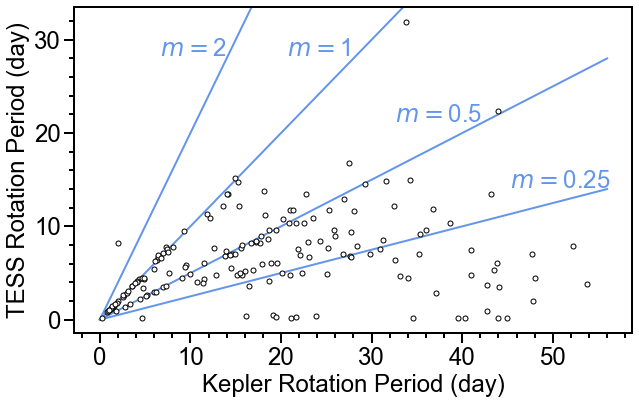

In [130]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    kepler.prot, tess.period, 'o',
    color='k', mfc='white', ms=5, zorder=10
)

xmax = ax.get_xlim()[1]
ylim = ax.get_ylim()
x = np.arange(0, xmax)
slopes = [0.25, 0.5, 1, 2]
for i, slope in enumerate(slopes):
    y = slope*x
    ax.plot(x, y, '-', color='cornflowerblue')
    xtext = xmax*(len(slopes)-i)/len(slopes)
    ytext = slope*xtext
    ax.text(
        xtext, ytext, f'$m=${slope} ', 
        ha='right', color='cornflowerblue'
    )
    
ax.set_ylim(ylim)
ax.set_xlabel('Kepler Rotation Period (day)')
ax.set_ylabel('TESS Rotation Period (day)')
plt.savefig('kepler_tess_prot_comparison.pdf', bbox_inches='tight')